In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from openAIgym.data_extractor import *
import gym
import xgboost
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.python import debug as tf_debug

# sess = K.get_session()
# sess = tf_debug.LocalCLIDebugWrapperSession(sess)
# K.set_session(sess)


from sklearn.multioutput import MultiOutputRegressor

env = gym.make('LunarLander-v2')
de = DataExtractor(env,get_real_obs_for_luner_lander,RandomLunarAgent())
cache_de = CachingExtractorDecorator(de)

# import datetime
# log_dir = "./tensorboard_log_dir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2021-10-20 16:09:55.745071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-20 16:09:55.745099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'tensorflow_addons'

In [3]:

# regressor1 = MultiOutputRegressor(regressor1)

ANGLE = 4
ANGULAR_VEL = 5
ACTION = 8
sub_target = ANGULAR_VEL
inputs = range(0,12)
test_data = cache_de.get_data(1000, 100).sub_target_dataset(sub_target).sub_input_dataset(inputs)
val_data = cache_de.get_data(2000, 100).sub_target_dataset(sub_target).sub_input_dataset(inputs)
train_data = cache_de.get_data(3000, 100).sub_target_dataset(sub_target).sub_input_dataset(inputs)

test_data = cache_de.get_data(1000, 100)
val_data = cache_de.get_data(2000, 100)
train_data = cache_de.get_data(3000, 100)

In [4]:
train_data.x[0]

array([ 9.94287395e+00,  1.33900652e+01, -2.89319396e+00,  2.52981567e+00,
        6.62625814e-03,  3.27676058e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [17]:
regressor1 = xgboost.XGBRegressor(
  objective ='reg:squarederror',
  colsample_bytree = 0.3,
  learning_rate = 0.05,
  max_depth = 5,
  alpha = 10,
  n_estimators = 200
)
regressor1 = MultiOutputRegressor(regressor1)

regressor1.fit(train_data.x, train_data.y)

train_pred = regressor1.predict(train_data.x)
train_errors = train_data.y-train_pred
test_pred = regressor1.predict(test_data.x)
errors = test_data.y-test_pred
xgerr = np.mean(np.absolute(errors),axis=0)
xgerr

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([0.01024665, 0.00951665, 0.03106144, 0.05237682, 0.00491441,
       0.05671063, 0.01124401, 0.01248224])

In [111]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras_contrib.callbacks import CyclicLR

def baseline_model():
    model = Sequential()
#     model.add(Dense(20, input_dim=12, activation='relu'))
    model.add(Dense(1,input_dim=12))
    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.001,
        maximal_learning_rate=0.01,
        scale_fn=lambda x: 1.,
        scale_mode="cycle",
        step_size=10
    )
    adam = tf.optimizers.Adam(clr)
    model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.SGD(learning_rate=0.0001))
    return model
  
nnRegressor = KerasRegressor(build_fn=baseline_model, batch_size=1000,
                             validation_data = (val_data.x, val_data.y),
                             verbose=True,shuffle=True
                             # callbacks = [tensorboard_callback]
                            )


nnRegressor.fit(train_data.x, train_data.y, epochs=10)
train_pred = nnRegressor.predict(train_data.x)
train_errors = train_data.y-train_pred
test_pred = nnRegressor.predict(test_data.x)
errors = test_data.y-test_pred
np.mean(np.absolute(errors),axis=0)-xgerr

Epoch 1/10
9/9 [==============================] - 0s 18ms/step - loss: 4.0544 - val_loss: 4.0044
Epoch 2/10
9/9 [==============================] - 0s 6ms/step - loss: 3.8444 - val_loss: 3.7990
Epoch 3/10
9/9 [==============================] - 0s 6ms/step - loss: 3.6374 - val_loss: 3.5983
Epoch 4/10
9/9 [==============================] - 0s 6ms/step - loss: 3.4356 - val_loss: 3.4036
Epoch 5/10
9/9 [==============================] - 0s 6ms/step - loss: 3.2402 - val_loss: 3.2159
Epoch 6/10
9/9 [==============================] - 0s 5ms/step - loss: 3.0529 - val_loss: 3.0366
Epoch 7/10
9/9 [==============================] - 0s 5ms/step - loss: 2.8751 - val_loss: 2.8671
Epoch 8/10
9/9 [==============================] - 0s 6ms/step - loss: 2.7079 - val_loss: 2.7090
Epoch 9/10
9/9 [==============================] - 0s 5ms/step - loss: 2.5539 - val_loss: 2.5629
Epoch 10/10
9/9 [==============================] - 0s 882us/step


2.352958019119471

In [114]:
nnRegressor.fit(train_data.x, train_data.y, initial_epoch=10, epochs=20)


Epoch 11/20
9/9 [==============================] - 0s 21ms/step - loss: 3.5618 - val_loss: 3.6287
Epoch 12/20
9/9 [==============================] - 0s 6ms/step - loss: 3.5172 - val_loss: 3.5715
Epoch 13/20
9/9 [==============================] - 0s 6ms/step - loss: 3.4756 - val_loss: 3.5180
Epoch 14/20
9/9 [==============================] - 0s 6ms/step - loss: 3.4375 - val_loss: 3.4681
Epoch 15/20
9/9 [==============================] - 0s 5ms/step - loss: 3.4022 - val_loss: 3.4205
Epoch 16/20
9/9 [==============================] - 0s 6ms/step - loss: 3.3691 - val_loss: 3.3757
Epoch 17/20
9/9 [==============================] - 0s 6ms/step - loss: 3.3381 - val_loss: 3.3336
Epoch 18/20
9/9 [==============================] - 0s 7ms/step - loss: 3.3093 - val_loss: 3.2943
Epoch 19/20
9/9 [==============================] - 0s 6ms/step - loss: 3.2827 - val_loss: 3.2573
Epoch 20/20
9/9 [==============================] - 0s 6ms/step - loss: 3.2581 - val_loss: 3.2225


In [55]:
nnRegressor.set_params(**dict(epochs=100))
nnRegressor.get_params()

{'epochs': 100,
 'batch_size': 1000,
 'validation_data': (array([[10.00281334, 13.39479446,  0.14236449, ...,  0.        ,
           1.        ,  0.        ],
         [10.00654888, 13.45612431,  0.1861635 , ...,  0.        ,
           0.        ,  0.        ],
         [10.01028538, 13.51345921,  0.18616121, ...,  0.        ,
           1.        ,  0.        ],
         ...,
         [ 9.25862789,  4.55114365,  0.69294518, ...,  0.        ,
           0.        ,  1.        ],
         [ 9.27267647,  4.32539415,  0.73725742, ...,  1.        ,
           0.        ,  0.        ],
         [ 9.28615761,  4.09599638,  0.70077342, ...,  0.        ,
           0.        ,  0.        ]]),
  array([ 2.23675286e-02, -1.55502930e-05,  2.02688631e-02, ...,
         -1.08661920e-01,  9.06152129e-02,  6.73120350e-01])),
 'verbose': True,
 'shuffle': True,
 'build_fn': <function __main__.baseline_model()>}

In [106]:
nnRegressor.model.set_weights([np.array([[ 0.0],
        [-0.0],
        [-0.0],
        [ 0.0],
        [-0.0],
        [-0.0],
        [-0.0],
        [-0.0],
        [ 0.0],
        [0.1],
        [-0.00 ],
        [-0.1]], dtype=np.float32),
 np.array([0.], dtype=np.float32)])

In [95]:
print(nnRegressor.model.get_weights())
train_pred = nnRegressor.predict(train_data.x)
train_errors = train_data.y-train_pred
print(np.sum(np.absolute(train_errors)))
test_pred = nnRegressor.predict(test_data.x)
errors = test_data.y-test_pred

[array([[ 0.11421993],
       [-0.01627145],
       [-0.05940893],
       [ 0.00278835],
       [ 0.27064958],
       [-0.01215146],
       [ 0.1380663 ],
       [-0.14306177],
       [-0.33118525],
       [ 0.1274061 ],
       [-0.32174045],
       [ 0.15905309]], dtype=float32), array([-0.01163554], dtype=float32)]
9/9 [==============================] - 0s 1ms/step
7928.069167375565
9/9 [==============================] - 0s 1ms/step


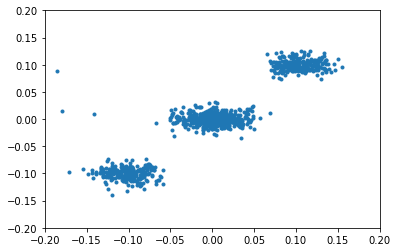

In [93]:
def rand_jitter(arr):
    stdev = .01 
    return arr + np.random.randn(len(arr)) * stdev

fig, ax = plt.subplots()
# ax.scatter(train_data.x[:,sub_target], train_data.y)
# ax.hist2d(train_data.x[:,ACTION], train_data.y,bins = (10,1000))
# ax.hist2d(train_data.x[:,ANGULAR_VEL], train_data.x[:,ANGLE],bins = (100,100))
# ax.scatter(rand_jitter(train_data.x[:100,ACTION+3]), rand_jitter(train_data.y[:100]))
# ax.scatter(rand_jitter(test_data.x[:100,ACTION+1]), rand_jitter(test_data.y[:100]))
ax.scatter(rand_jitter(test_data.y[:1000]), rand_jitter(test_pred[:1000]),marker='.')
# ax.hist2d(test_data.y[:1000], test_pred[:1000],bins=(1000,100))
ax.set_xlim(-.2, .2)
ax.set_ylim(-.2, .2)
# ax.grid()
plt.show()


In [32]:
n += 1
test_data.y[n], test_pred[n], test_data.x[n]

(0.032638609409332275, -0.07747877, array([0., 0., 1., 0.]))

In [64]:
# n=0
test_pred
# n+=1
# train_data.x[n,ACTION], train_data.y[n]
# np.diff(all_obs, axis=0)

array([0.01169274, 0.01169274, 0.01169274, ..., 0.01169274, 0.01169274,
       0.01169274], dtype=float32)

In [105]:

import random
import numpy as np
import xgboost
from sklearn.multioutput import MultiOutputRegressor

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from Box2D import b2Vec2
from openAIgym.data_extractor import *
# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = DQN('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=int(2e2))
# Save the agent
model.save("dqn_lunar")
del model  # delete trained model to demonstrate loading

# Load the trained agent
model = DQN.load("dqn_lunar", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [127]:
obs = env.reset()
np.set_printoptions(precision=3)
for i in range(10):
#     action, _states = model.predict(obs, deterministic=True)
    action = i % 4
    print(obs, action)
    old_obs = obs
    obs, rewards, dones, info = env.step(action)
    print(env.lander.angularVelocity)
    env.render()

[-7.038e-05  1.419e+00 -7.140e-03  3.566e-01  8.831e-05  1.617e-03
  0.000e+00  0.000e+00] 0
0.004002718720585108
[-1.409e-04  1.426e+00 -7.130e-03  3.309e-01  1.683e-04  1.601e-03
  0.000e+00  0.000e+00] 1
0.10138650983572006
[-2.888e-04  1.433e+00 -1.684e-02  3.045e-01  2.196e-03  4.055e-02
  0.000e+00  0.000e+00] 2
0.07668130844831467
[-5.412e-04  1.441e+00 -2.679e-02  3.285e-01  3.729e-03  3.067e-02
  0.000e+00  0.000e+00] 3
-0.02940422296524048
[-7.092e-04  1.447e+00 -1.621e-02  3.017e-01  3.141e-03 -1.176e-02
  0.000e+00  0.000e+00] 0
-0.02936341054737568
[-8.774e-04  1.454e+00 -1.621e-02  2.750e-01  2.554e-03 -1.175e-02
  0.000e+00  0.000e+00] 1
0.06489536911249161
[-1.120e-03  1.459e+00 -2.562e-02  2.486e-01  3.852e-03  2.596e-02
  0.000e+00  0.000e+00] 2
0.02321477420628071
[-0.002  1.465 -0.042  0.25   0.004  0.009  0.     0.   ] 3
-0.08094526827335358
[-0.002  1.47  -0.032  0.224  0.003 -0.032  0.     0.   ] 0
-0.08090493083000183
[-2.213e-03  1.474e+00 -3.202e-02  1.973e-01

In [341]:
# action, _states = model.predict(obs, deterministic=True)
env.render()
obs, rewards, dones, info = env.step(0)
obs, rewards, dones, info

(array([0.12565127, 0.00104049, 0.        , 0.        , 0.01433016,
        0.        , 0.        , 0.        ], dtype=float32),
 100,
 True,
 {})

In [356]:
xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 1000)
xg_reg = MultiOutputRegressor(xg_reg)
xg_reg.fit(train_dataX,train_dataY)

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MultiOutputRegressor(estimator=XGBRegressor(alpha=10, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_

In [418]:
env.reset()
prev_obs = get_real_obs(env)

In [613]:
action = 1
next_state = prev_obs + xg_reg.predict(np.concatenate([prev_obs,[action]]).reshape(1, -1))
next_state = next_state.reshape(-1)
env.step(action)
obs = get_real_obs(env)
l = env.lander
l.position=b2Vec2(next_state[0],next_state[1])
l.linearVelocity=b2Vec2(next_state[2],next_state[3])
l.angle = next_state[4]
l.angularVelocity = next_state[5]
env.render()
prev_obs = obs


In [614]:
test_pred = xg_reg.predict(test_dataX)

array([  0.2873213 ,   0.35183179,   9.93375767,  83.115664  ,
         0.14197949, 137.76132054,   2.58090231,   7.95803136])

In [2]:

c1 = gym.make('CartPole-v1')
c1.reset()
c1.render()

True

In [3]:
c2 = gym.make('CartPole-v1')

c2.reset()
c2.render()

True

True